In [35]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import cv2
import numpy as np
from corners import *
import random

In [228]:
def loadImages():
    images = []
    for i in range(1,11):
        location = r"imgs/%d.jpg"%i
        img = rgb2gray(mpl.image.imread(location))
        images.append(img)
    return images

In [234]:
def getFeaturePoints(img, winSize=21):
    result = cornerDetect(img, winSize, k=0.04, thd=1e14, type=1)
    # Non maximum suppression
    tempScale = np.pad(result, 2, mode='constant')
    width, height = tempScale.shape
    for x in range(2, width-2):
        for y in range(2, height-2):
            if tempScale[x][y] != np.max(tempScale[x-2:x+3, y-2:y+3]):
                tempScale[x][y] = 0
    result = tempScale[2:width-2, 2:height-2]
    y, x = np.nonzero(result)
    print('Number of corner : %d'%y.shape)
    return x,y

In [4]:
def getFeatureDescriptors(X, Y, winSize, img):
    neighbors = []
    descriptors = []
    newPoint = []
    for x, y in zip(X,Y):
        patch_center = np.array([x, y])
        image = np.array(img)
        patch_size = winSize
        patch_x = int(patch_center[1] - patch_size / 2.)
        patch_y = int(patch_center[0] - patch_size / 2.)
        if patch_x < 0 or patch_y < 0:
            #print('!')
            continue
        else:
            patch_image = image[patch_x:patch_x+patch_size, patch_y:patch_y+patch_size]
            #patch_image = np.float32(patch_image)/255.0
            patch_image = patch_image.astype(np.uint8)
            neighbors.append(patch_image.flatten())
            newPoint.append([x,y])
    return np.array(newPoint), np.array(neighbors)

In [80]:
def match2Images(desc1, keypoint1, desc2, keypoint2, type='ncc', th = 2):
    dist = []
    keypoints = []
    
    for des1, key1 in zip(desc1, keypoint1):
        for des2, key2 in zip(desc2, keypoint2):
            if type == 'ncc':
                des1Norm = des1 / np.sqrt((np.sum(des1**2)))
                des2Norm = des2 / np.sqrt((np.sum(des2**2)))
                distance = np.dot(des1Norm.T,des2Norm)
                dist.append(distance)
                keypoints.append((key1, key2))
            elif type == 'euclidean':
                dist.append(np.sqrt(np.sum((des1-des2)**2)))
                keypoints.append((key1, key2))
            else:
                print('type error : use [ncc] or [euclidean]')
                
    dist = np.array(dist)
    keypoints = np.array(keypoints)
    if type == 'ncc':
        print('#ncc# min : %0.0f, max : %0.0f'%(min(dist),max(dist)))
        temp = dist < th
        idxOfCorrectMatching = np.nonzero(temp)
    elif type == 'euclidean':
        print('#euclidean#  min : %0.0f, max : %0.0f'%(min(dist),max(dist)))
        temp = dist < th
        idxOfCorrectMatching = np.nonzero(temp)
    else:
        print('type error : use [ncc] or [euclidean]')
    candidateCorrespondences = []
    for i in idxOfCorrectMatching:
        candidateCorrespondences.append(keypoints[i])
    return np.array(candidateCorrespondences).reshape(len(candidateCorrespondences[0]),2,2)

In [6]:
def refineMatches(feature_points, match_list):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-6-bbdcf7edc8fc>, line 2)

그레이스케일된 이미지를 불러온다. 리스트로 10장

In [231]:
images = loadImages()

각 이미지의 코너를 DETECT한다.
이미지 마다 DETECT된 코너좌표를 리스트로 저장 imgX[0~9], imgY[0~9]
# 10장 다 해야해서 오래걸림;;

Number of corner : 2474
Number of corner : 2405
Number of corner : 2816
Number of corner : 1684
Number of corner : 2575
Number of corner : 1349
Number of corner : 2265
Number of corner : 1866
Number of corner : 1456
Number of corner : 1989


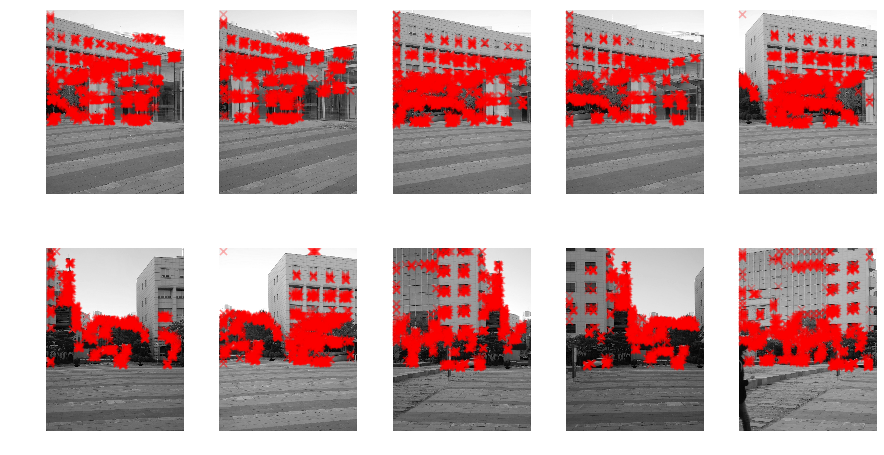

In [240]:
imgX = []
imgY = []
fig = plt.figure(figsize=(15,8))
for i in range(10):
    X,Y = getFeaturePoints(images[i], 40)
    imgX.append(X)
    imgY.append(Y)
    ax = fig.add_subplot(2,5,i+1)
    ax.imshow(images[i], cmap='gray')
    ax.scatter(imgX[i], imgY[i], 50, marker='x', alpha = 0.3,color='r')
    ax.axis('off')
plt.show()

Number of corner : 1989


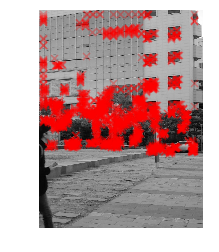

In [239]:
fig = plt.figure()
X,Y = getFeaturePoints(images[i],40)
plt.imshow(images[i], cmap='gray')
plt.scatter(X, Y, 50, marker='x', alpha = 0.3,color='r')
plt.axis('off')
plt.show()

test로 첫번째 두번째 이미지의 flatten된 feature를 뽑는다. 

In [50]:
keypoint1, desc1 = getFeatureDescriptors(imgX[0], imgY[0], 5, images[0])

In [51]:
keypoint2, desc2 = getFeatureDescriptors(imgX[1], imgY[1], 5, images[1])

feature사이에 거리를 기준으로 일정 쓰레시홀드 안에 들어오는 쌍들을 찾는다. 

In [52]:
candidate = match2Images(desc1,keypoint1,desc2,keypoint2,'ncc')
print('find %d matches'%len(candidate))

#ncc# min : 1, max : 844
find 143 matches


매칭쌍들의 좌표를 스플릿하여 저장

In [53]:
img1X_candi = candidate[:,:1,:1].reshape(len(candidate))
img1Y_candi = candidate[:,:1,1:].reshape(len(candidate))
img2X_candi = candidate[:,1:,:1].reshape(len(candidate))
img2Y_candi = candidate[:,1:,1:].reshape(len(candidate))

각각의 이미지에 매칭쌍 좌표 출력

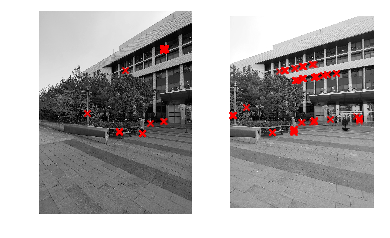

In [54]:
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.imshow(images[0], cmap='gray')
ax1.scatter(img1X_candi, img1Y_candi, marker='x', alpha = 0.7,color='r')
ax1.axis('off')
ax2.imshow(images[1], cmap='gray')
ax2.scatter(img2X_candi, img2Y_candi, marker='x', alpha = 0.7,color='r')
ax2.axis('off')
plt.show()

아홉번째와 열번째 이미지 도 마찬가지로 테스트

In [299]:
keypoint8, desc8 = getFeatureDescriptors(imgX[0], imgY[0], 30, images[0])
keypoint9, desc9 = getFeatureDescriptors(imgX[3], imgY[3], 30, images[3])

In [300]:
candidate = match2Images(desc8,keypoint8,desc9,keypoint9,'euclidean', 160)
print('find %d matches'%len(candidate))

#euclidean#  min : 113, max : 352
find 25 matches


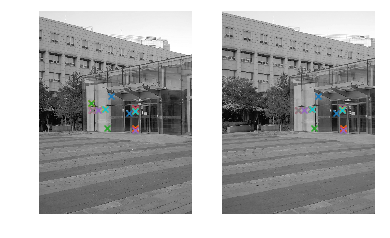

In [301]:
img1X_candi = candidate[:,:1,:1].reshape(len(candidate))
img1Y_candi = candidate[:,:1,1:].reshape(len(candidate))
img2X_candi = candidate[:,1:,:1].reshape(len(candidate))
img2Y_candi = candidate[:,1:,1:].reshape(len(candidate))

fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.imshow(images[0], cmap='gray')
ax2.imshow(images[3], cmap='gray')
for x1, y1, x2, y2 in zip(img1X_candi, img1Y_candi, img2X_candi, img2Y_candi):
    ax1.scatter(x1, y1, marker='x')
    ax2.scatter(x2, y2, marker='x')
ax1.axis('off')
ax2.axis('off')
plt.show()

test

In [260]:
def calculateHomography(correspondences):
    #loop through correspondences and create assemble matrix
    aList = []
    for corr in correspondences:
        p1 = np.matrix([corr.item(0), corr.item(1), 1])
        p2 = np.matrix([corr.item(2), corr.item(3), 1])

        a2 = [0, 0, 0, -p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2),
              p2.item(1) * p1.item(0), p2.item(1) * p1.item(1), p2.item(1) * p1.item(2)]
        a1 = [-p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2), 0, 0, 0,
              p2.item(0) * p1.item(0), p2.item(0) * p1.item(1), p2.item(0) * p1.item(2)]
        aList.append(a1)
        aList.append(a2)

    matrixA = np.matrix(aList)

    #svd composition
    u, s, v = np.linalg.svd(matrixA)

    #reshape the min singular value into a 3 by 3 matrix
    h = np.reshape(v[8], (3, 3))

    #normalize and now we have h
    h = (1/h.item(8)) * h
    return h

In [261]:
def geometricDistance(correspondence, h):

    p1 = np.transpose(np.matrix([correspondence[0].item(0), correspondence[0].item(1), 1]))
    estimatep2 = np.dot(h, p1)
    estimatep2 = (1/(estimatep2.item(2) + 1e-8))*estimatep2

    p2 = np.transpose(np.matrix([correspondence[0].item(2), correspondence[0].item(3), 1]))
    error = p2 - estimatep2
    return np.linalg.norm(error)

In [262]:
def ransac(corr, thresh):
    maxInliers = []
    min_residual = -99999
    finalH = None
    for i in range(1000):
        #find 4 random points to calculate a homography
        corr1 = corr[random.randrange(0, len(corr))]
        corr2 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((corr1, corr2))
        corr3 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((randomFour, corr3))
        corr4 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((randomFour, corr4))

        #call the homography function on those points
        h = calculateHomography(randomFour)
        inliers = []
        
        residual = 0
        for i in range(len(corr)):
            d = geometricDistance(corr[i], h)
            residual = residual + d
            if d < thresh:
                inliers.append(corr[i])
            
        avg_residual = residual / len(corr)

        if len(inliers) > len(maxInliers):
            finalH = h
            maxInliers = inliers
            
        print("step: ", i, " average residual: ", avg_residual, " NumInliers: ", len(inliers))
        
    return finalH, maxInliers

In [302]:
correspondenceList = []
for x1, y1, x2, y2 in zip(img1X_candi, img1Y_candi, img2X_candi, img2Y_candi):
        correspondenceList.append([x1, y1, x2, y2])
corrs = np.matrix(correspondenceList)
inlier_thresh = 10
finalH, inliers = ransac(corrs, inlier_thresh)

step:  24  average residual:  13.142659611412826  NumInliers:  14
step:  24  average residual:  104.31706860498447  NumInliers:  11
step:  24  average residual:  18.71962205752814  NumInliers:  12
step:  24  average residual:  20.200067801328615  NumInliers:  9
step:  24  average residual:  60.48293575849473  NumInliers:  8
step:  24  average residual:  179.73830141288977  NumInliers:  11
step:  24  average residual:  14.793609537246885  NumInliers:  12
step:  24  average residual:  181.93442440440947  NumInliers:  5
step:  24  average residual:  16.376348650097157  NumInliers:  13
step:  24  average residual:  78.7880436286335  NumInliers:  11
step:  24  average residual:  115.90590470427428  NumInliers:  6
step:  24  average residual:  65.59256987891123  NumInliers:  11
step:  24  average residual:  10.466346117987841  NumInliers:  14
step:  24  average residual:  17.040714240383014  NumInliers:  13
step:  24  average residual:  4.852814370221329  NumInliers:  23
step:  24  average r

step:  24  average residual:  207.4601297165261  NumInliers:  4
step:  24  average residual:  310.39717330140263  NumInliers:  7
step:  24  average residual:  165.813103737347  NumInliers:  7
step:  24  average residual:  12.480873094017452  NumInliers:  14
step:  24  average residual:  78.45649994431258  NumInliers:  14
step:  24  average residual:  330.66972588972834  NumInliers:  10
step:  24  average residual:  230.5648155048579  NumInliers:  6
step:  24  average residual:  9.718648381060099  NumInliers:  18
step:  24  average residual:  4.468189210024093  NumInliers:  23
step:  24  average residual:  17.35289739832788  NumInliers:  16
step:  24  average residual:  169.78016843275608  NumInliers:  5
step:  24  average residual:  4.417313749264116  NumInliers:  23
step:  24  average residual:  75.83675873860366  NumInliers:  10
step:  24  average residual:  218.032811970849  NumInliers:  10
step:  24  average residual:  4.296024113341454  NumInliers:  23
step:  24  average residual:

step:  24  average residual:  4.943406963259328  NumInliers:  21
step:  24  average residual:  184.19618187859928  NumInliers:  6
step:  24  average residual:  42.77270456666061  NumInliers:  8
step:  24  average residual:  73.16358418095369  NumInliers:  8
step:  24  average residual:  71.82003347474705  NumInliers:  12
step:  24  average residual:  270.14969607572567  NumInliers:  7
step:  24  average residual:  86.66666308699219  NumInliers:  8
step:  24  average residual:  4560.188485275014  NumInliers:  8
step:  24  average residual:  926.5953067147644  NumInliers:  6
step:  24  average residual:  61.6403857937167  NumInliers:  13
step:  24  average residual:  79.53950146507057  NumInliers:  12
step:  24  average residual:  42.346896829186434  NumInliers:  12
step:  24  average residual:  4.279927253144392  NumInliers:  23
step:  24  average residual:  4.060569975593669  NumInliers:  23
step:  24  average residual:  23.91046319247412  NumInliers:  11
step:  24  average residual:  

step:  24  average residual:  184.28511189922426  NumInliers:  6
step:  24  average residual:  153.75617130482064  NumInliers:  5
step:  24  average residual:  4.162293274444146  NumInliers:  23
step:  24  average residual:  714.8592047407847  NumInliers:  1
step:  24  average residual:  8.32018261239058  NumInliers:  20
step:  24  average residual:  174.25498582798346  NumInliers:  13
step:  24  average residual:  117.90153607738065  NumInliers:  9
step:  24  average residual:  26.260431967339514  NumInliers:  7
step:  24  average residual:  80.66622801469708  NumInliers:  10
step:  24  average residual:  12.272790347948284  NumInliers:  12
step:  24  average residual:  233.3765440480074  NumInliers:  9
step:  24  average residual:  53.28439086829867  NumInliers:  10
step:  24  average residual:  185.38033079659124  NumInliers:  10
step:  24  average residual:  230.7108822772949  NumInliers:  14
step:  24  average residual:  59.45492593846218  NumInliers:  6
step:  24  average residua

step:  24  average residual:  14.595863621022213  NumInliers:  14
step:  24  average residual:  26.541253445101034  NumInliers:  12
step:  24  average residual:  17.94004147001432  NumInliers:  9
step:  24  average residual:  37.66050267091072  NumInliers:  12
step:  24  average residual:  5.029043436739832  NumInliers:  21
step:  24  average residual:  180.21932394365209  NumInliers:  6
step:  24  average residual:  203.31205986364367  NumInliers:  5
step:  24  average residual:  109.50254592062973  NumInliers:  7
step:  24  average residual:  5.215035884333782  NumInliers:  23
step:  24  average residual:  495.8194320252351  NumInliers:  12
step:  24  average residual:  20.490618270500942  NumInliers:  13
step:  24  average residual:  1278.134485775829  NumInliers:  14
step:  24  average residual:  10.241581624731811  NumInliers:  21
step:  24  average residual:  14.54996242805818  NumInliers:  13
step:  24  average residual:  4.936448856160853  NumInliers:  21
step:  24  average res

step:  24  average residual:  16.34369711154008  NumInliers:  9
step:  24  average residual:  60.73034445850232  NumInliers:  11
step:  24  average residual:  21.643884326199846  NumInliers:  13
step:  24  average residual:  171.38218178937132  NumInliers:  5
step:  24  average residual:  185.83187006237316  NumInliers:  9
step:  24  average residual:  15.819188994259124  NumInliers:  12
step:  24  average residual:  173.92162221513018  NumInliers:  7
step:  24  average residual:  47.04537774889071  NumInliers:  11
step:  24  average residual:  5.383163323268506  NumInliers:  23
step:  24  average residual:  45.42337920572718  NumInliers:  8
step:  24  average residual:  51.36225318309023  NumInliers:  15
step:  24  average residual:  7.8959048602326005  NumInliers:  16
step:  24  average residual:  15.765383923820405  NumInliers:  12
step:  24  average residual:  4.911196203457857  NumInliers:  23
step:  24  average residual:  27.42613035127732  NumInliers:  13
step:  24  average resi

step:  24  average residual:  476.2523860078372  NumInliers:  9
step:  24  average residual:  5.172841493352147  NumInliers:  21
step:  24  average residual:  171.6101747160969  NumInliers:  8
step:  24  average residual:  13.882624821580984  NumInliers:  13
step:  24  average residual:  174.98310459957003  NumInliers:  6
step:  24  average residual:  880.3284096968059  NumInliers:  9
step:  24  average residual:  14.524086160480799  NumInliers:  13
step:  24  average residual:  52.88363083516004  NumInliers:  11
step:  24  average residual:  108.22220869607409  NumInliers:  8
step:  24  average residual:  1360.9069529967753  NumInliers:  5
step:  24  average residual:  342.7434764192289  NumInliers:  18
step:  24  average residual:  9.620173765655148  NumInliers:  16
step:  24  average residual:  28.126163609214768  NumInliers:  9
step:  24  average residual:  18.28140001295804  NumInliers:  17
step:  24  average residual:  220.27504477156154  NumInliers:  9
step:  24  average residua

In [303]:
len(inliers)

23

In [304]:
inliers = np.array(inliers).reshape(-1, 4)

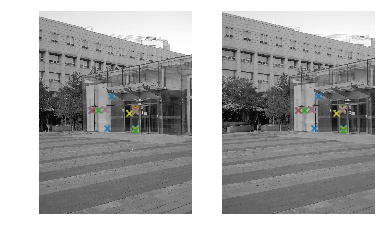

In [306]:
plt.show()
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.imshow(images[0], cmap='gray')
ax2.imshow(images[3], cmap='gray')
for x1, y1, x2, y2 in zip(inliers[:, 0], inliers[:, 1], inliers[:, 2], inliers[:, 3]):
    ax1.scatter(x1, y1, marker='x')
    ax2.scatter(x2, y2, marker='x')
ax1.axis('off')
ax2.axis('off')
plt.show()

In [307]:
finalH

matrix([[ 1.02077691e+00,  6.45398545e-02,  1.02334122e+02],
        [-3.87609974e-02,  1.09765162e+00, -1.86904311e+01],
        [-7.47993253e-05,  1.18832477e-04,  1.00000000e+00]])

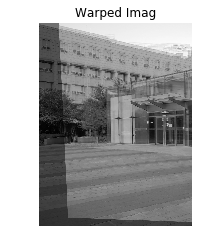

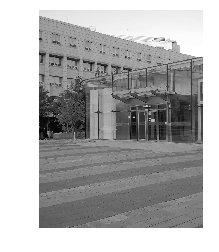

In [310]:
height, width = images[0].shape
dst = cv2.warpPerspective(images[0],finalH,(width, height))
plt.subplot(122)
plt.imshow(dst,cmap='gray')
plt.imshow(images[3],cmap='gray', alpha=0.5)
plt.title('Warped Imag')
plt.axis('off')
plt.show()
plt.figure()
dst[0:images[0].shape[0], 0:images[0].shape[1]] = images[0]
#cv2.imwrite(‘output.jpg’,dst)
plt.imshow(dst,cmap='gray')
plt.axis('off')
plt.show()